In [ ]:
# first we have to install some libraries in Colab
!pip install cftime
!pip install nc-time-axis
!pip install zarr==2.9
!pip install xarray==2024.1.0
!pip install gcsfs
!pip install cartopy

In [ ]:
# set up our libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

# set up cartopy
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# notebook display options
xr.set_options(display_style='html')
%matplotlib inline

# Load in data and perform clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Choose the sea ice concentration variable for the IPSL-CM6A-LR model in the SSP 5.85 scenario, drawn from the first ensemble member:

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_sic = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & variable_id == 'siconc' & experiment_id == 'ssp585' & institution_id == 'IPSL' & grid_label =='gn' & member_id =='r1i1p1f1'")
df_sic

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
279948,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r1i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190903


In [ ]:
# setup the gcs access
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to the zarr store (from the dataframe above)
zstore = df_sic.zstore.values[0]

# create a mapping interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)

Process the data:

In [ ]:
# restrict the data to the central Arctic region, north of 70°N
lat = ds['nav_lat'].compute()
ds=ds.where(lat > 70,drop=True)

ds

<xarray.Dataset>
Dimensions:         (y: 41, x: 192, time: 1032, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(41, 192, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(41, 192, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 62.02 62.32 62.62 62.91 ... 71.34 70.89 70.44
    nav_lon         (y, x) float32 112.9 113.8 114.7 115.7 ... 73.61 73.59 73.57
  * time            (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T...
    time_bounds     (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1032, 2), meta=np.ndarray>
    type            |S6 b'typesi'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area            (y, x) float32 dask.array<chunksize=(41, 192), meta=np.ndarray>
    siconc          (time, y, x) float32 dask.array<chunksize=(600, 41, 192), meta=np.ndarray>
Attributes: (12/54)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  ssp585
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    variable_id:            siconc
    variant_info:           Each member starts from the corresponding member ...
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/36c88679-f984-41a2-b7c9-a1287376c690
    version_id:             v20190903

In [ ]:
# extract the data for the first year only
ds_2015 = ds.sel(time=slice('01/01/2015','31/12/2015'))
# reshape the 2 spatial dimensions into 1 single dimension so that we can
# apply the KMeans method easily:
ds_2015 = ds_2015.stack({'position': ('y','x')})

The silhouette score is used to estimate how many clusters should be used:

In [ ]:
# use the silhouette score to estimate the optimal number of clusters
nb_clusters_max = 10
s = np.zeros(nb_clusters_max-2)
for k in range(2,nb_clusters_max):
  # Create the classifier:
  kmeans = KMeans(n_clusters=k, random_state=42)
  # Train the classifier:
  kmeans.fit(ds_2015.siconc.dropna(dim='position').T)
  # Classify the dataset:
  labels = kmeans.predict(ds_2015.siconc.dropna(dim='position').T)

  # Compute the silhouette score
  s[k-2] = silhouette_score(ds_2015.siconc.dropna(dim='position').T, labels)

  print('Number of clusters : {}, silhouette score : {:.2f}'.format(k,s[k-2]))

Number of clusters : 2, silhouette score : 0.49
Number of clusters : 3, silhouette score : 0.56
Number of clusters : 4, silhouette score : 0.53
Number of clusters : 5, silhouette score : 0.48
Number of clusters : 6, silhouette score : 0.49
Number of clusters : 7, silhouette score : 0.50
Number of clusters : 8, silhouette score : 0.47
Number of clusters : 9, silhouette score : 0.49


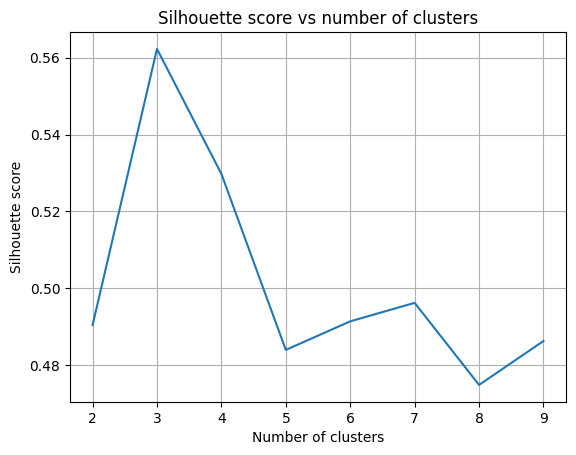

In [ ]:
plt.plot(np.arange(2,nb_clusters_max),s)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs number of clusters')
plt.grid()

The k-means clustering can now be performed using the number of clusters chosen based on the silhouette score:

In [ ]:
# fit the KMeans clusterer to the first available year of data, using the
# optimal number of clusters
nb_clusters=3
kmeans = KMeans(n_clusters=nb_clusters, random_state=42)
kmeans.fit(ds_2015.siconc.dropna(dim='position').T)

KMeans(n_clusters=3, random_state=42)

In [ ]:
# to make a map of the predictions, we need to know which locations are finite,
# and used in the calculation, and which points are excluded by the dropna
# we can then reconstruct the original-size array

# find the indices where there are data
finite_points = np.where(np.isfinite(ds_2015.siconc.sum(dim='time',skipna=False).values))[0]
# set up an empty array that is the same size as the original data set
labels = np.zeros_like(ds_2015.siconc.isel(time=0).data)*np.nan
# assign the label predictions to the correct points in the empty array
labels[finite_points] = kmeans.predict(ds_2015.siconc.dropna(dim='position').T)
# manually change the order of the label names so that the numbers are associated
# with increasing ice coverage for easier reference
labels[labels == 2] = 10
labels[labels == 1] = 11
labels[labels == 0] = 12
labels = labels - 10

# now make use of the coordinates of the original data set to create a new
# data array for the labels
da_labels = ds_2015.isel(time=0).assign({'labels': ('position', labels)})
da_labels = da_labels.labels.unstack()

# calculate the mean seasonal cycle for each of the clusters in 2015
scycle = np.zeros((nb_clusters,12))
dset = ds_2015.assign({'labels': ('position', labels)})
for i in range(nb_clusters):
  scycle[i,:] = dset.where(dset['labels']==i).mean(dim=('position')).siconc.values

In [ ]:
# count how many points are in each cluster for each year to see the temporal evolution
from tqdm.notebook import tqdm

counts = np.zeros((3,len(np.unique(ds.time.dt.year.data))))

for iy,y in enumerate(tqdm(np.unique(ds.time.dt.year.data))):
  dsy = ds.sel(time=slice('{}-01-01'.format(y),'{}-12-31'.format(y)))
  dset = dsy.siconc.stack({'position': ('y','x')})

  # Classify the dataset:
  lab = kmeans.predict(dset.dropna(dim='position').T)
  # manually change the order of the label names so that the numbers are associated
  # with increasing ice coverage for easier reference
  lab[lab == 2] = 10
  lab[lab == 1] = 11
  lab[lab == 0] = 12
  lab = lab - 10

  # Count how many points in each cluster
  counts[:,iy],_ = np.histogram(lab,bins=np.arange(0,nb_clusters+1)-0.5)

  0%|          | 0/86 [00:00<?, ?it/s]

Text(0.5, 1.0, '')

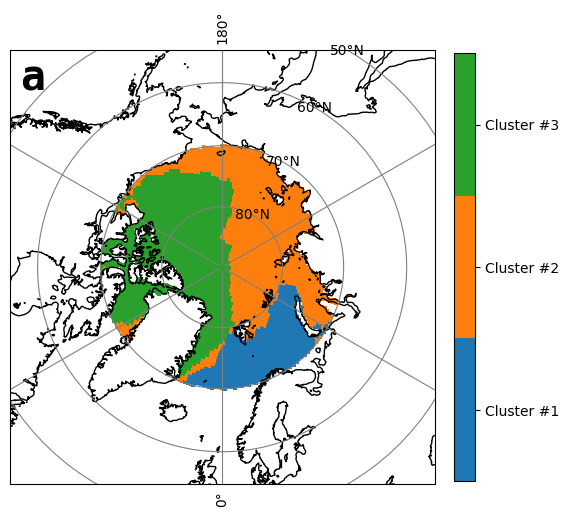

In [ ]:
# make a discrete colour map so that we can use the same colours in all the figures
from matplotlib.colors import ListedColormap
dmap = ListedColormap(['tab:blue', 'tab:orange', 'tab:green'])

plt.figure(figsize=(6,6.5))
ax = plt.axes(projection=ccrs.NorthPolarStereo());
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
pm = da_labels.plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),x='nav_lon', y='nav_lat', add_colorbar=False, cmap=dmap);
cb = plt.colorbar(pm, fraction=0.046, pad=0.04)
cb.set_ticks([1/3,1,10/6])
cb.set_ticklabels(['Cluster #1', 'Cluster #2', 'Cluster #3'])
ax.coastlines();
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');
plt.text(-135, 50, 'a', fontsize=30, fontweight='bold',
         horizontalalignment='right', fontfamily='monospace',
         transform=ccrs.Geodetic())
plt.title('')

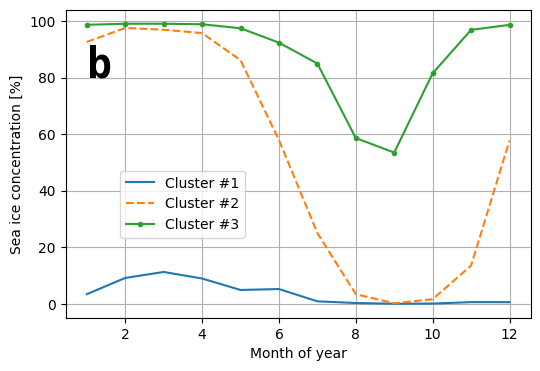

In [ ]:
plt.figure(figsize=(6,4))

p1 = plt.plot(np.arange(1,13),scycle[0,:],'-',label='Cluster #1')
p2 = plt.plot(np.arange(1,13),scycle[1,:],'--', label='Cluster #2')
p3 = plt.plot(np.arange(1,13),scycle[2,:],'.-', label='Cluster #3')
plt.grid()
plt.xlabel('Month of year')
plt.ylabel('Sea ice concentration [%]')
plt.text(1,80,'b', fontsize=30, fontweight='bold',fontfamily='monospace')
plt.legend(loc='best',bbox_to_anchor=(0,0,0.4,0.5))

Text(0.5, 0, 'Year')

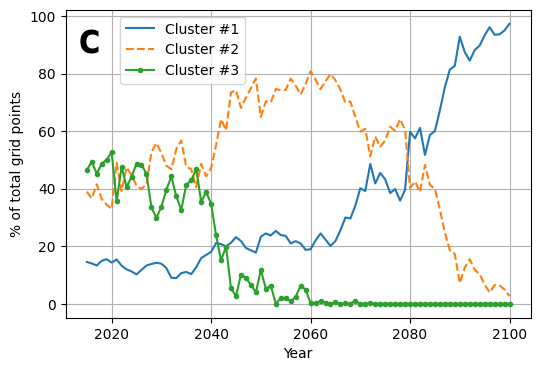

In [ ]:
plt.figure(figsize=(6,4))
p0 = plt.plot(np.unique(ds.time.dt.year.data),100*counts[0,:]/len(finite_points), '-', label='Cluster #1')
p1 = plt.plot(np.unique(ds.time.dt.year.data),100*counts[1,:]/len(finite_points), '--', label='Cluster #2')
p2 = plt.plot(np.unique(ds.time.dt.year.data),100*counts[2,:]/len(finite_points), '.-', label='Cluster #3')
plt.grid()
plt.text(2013,87,'c', fontsize=30, fontweight='bold',fontfamily='monospace')
plt.legend(loc='best',bbox_to_anchor=(0,0.5,0.4,0.5))
plt.ylabel('% of total grid points')
plt.xlabel('Year')